## **Aim** : Car price analysis

![cars](https://miro.medium.com/max/1296/1*kQBj7l-Y1WPZfX9nKIYL1Q.jpeg)


**Description** : Perform EDA on old cars dataset provided and use that to predict likely prices of a unknown car with known characterstics 

**Required libraries/modules**

In [50]:
#@title
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Understand Dataset**

In [51]:
data = pd.read_excel('./data/train_data.xlsx')
data[0:2]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50


As you can see there are units like (km/kg,kmpl) ,CC,bhp in Mileage,Engine,Power columns 
respectively which are not needed at all so first we will remove them

**Data Cleaning**

In [52]:

def data_clean(data) :  
    # Modify Columsn

    data['Mileage']=data.Mileage.str.replace('km/kg','').str.replace('kmpl','').astype(float)
    data['Engine']=data.Engine.str.replace('CC','').astype(float)
    data['Power']=data.Power.str.replace(' bhp','')

    # Splitting Name Column in carName, carBodyStyle, carTrimLevel and drop carTrimLevel

    CarName=data.Name.str.split(' ').apply(lambda x : x[0])
    CarBodyStyle=data.Name.str.split(' ').apply(lambda x :x[1])
    CarTrimLevel=data.Name.str.split(' ').apply(lambda x : x[2:])
    CarName=pd.Series(CarName,name='CarName')
    BodyStyle=pd.Series(CarBodyStyle,name='BodyStyle')
    data = pd.concat([CarName, CarBodyStyle, data.iloc[:,1:]],axis=1)

    return data 

**Check for null values**

In [53]:
data = data_clean(data)
data.isnull().sum()

CarName               0
Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

In [54]:
# So there are null values in data . 
# There is something that i found that in power column null values are more than 36 .Why ? 
# because inplace of null values they have added the the string 'null bhp'.
# so that also need attention. 

data.loc[data['Power']=='null','Power']=np.nan  # filling string 'null' with np.nan(Null type)


**Check outliers**

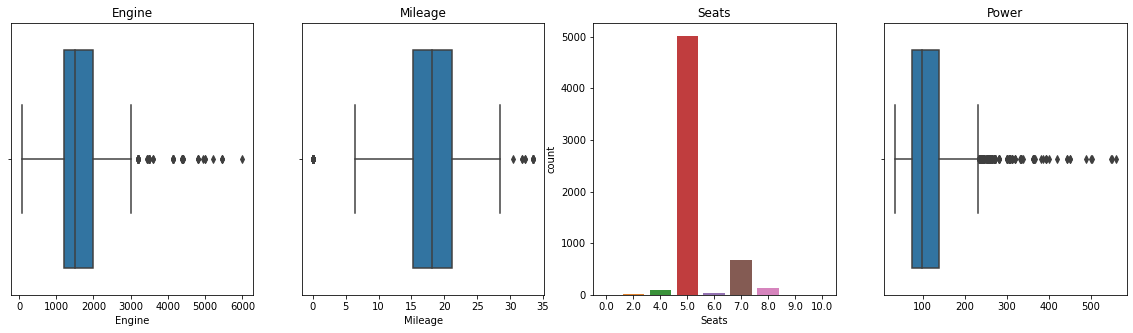

In [55]:
fig, axis = plt.subplots(1,4, figsize = (20,5))

plt.subplot(axis[0])
axis[0].title.set_text('Engine')
sns.boxplot('Engine',data=data)

plt.subplot(axis[1])
axis[1].title.set_text('Mileage')
sns.boxplot('Mileage',data=data)

plt.subplot(axis[2])
axis[2].title.set_text('Seats')
sns.countplot(data['Seats'])

plt.subplot(axis[3])
axis[3].title.set_text('Power')
power=data['Power'][data['Power'].isnull()==False].astype(float).values
sns.boxplot(power)

**Comments:-**
- It is safe to fill null values of Seats with 5 .
- As there are outliers in Engine,Mileage and Power that are far from mean so It is better to fill their null value with mode.

**Filling Null values**

In [56]:
modeEngine=statistics.mode(data['Engine'])
data['Engine'].fillna(modeEngine,inplace=True) 

modeMileage=statistics.mode(data['Mileage'].values)
data['Mileage'].fillna(modeMileage,inplace=True)

data.Seats.fillna(5,inplace=True)

modePower=statistics.mode(power)
data['Power'].fillna(modePower,inplace=True)
data['Power']=data['Power'].astype(float)

In [57]:
data.isnull().sum()

CarName              0
Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

**No more null values . Phew....**

**EDA**

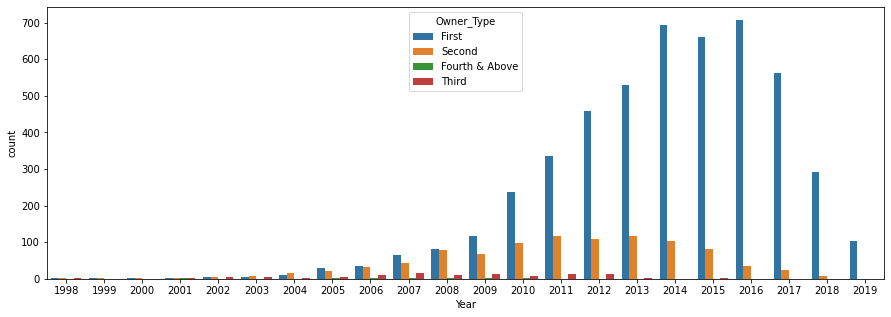

In [58]:
plt.figure(figsize=(15,5))
sns.countplot(data['Year'], hue= data['Owner_Type'])

- This Chart Shows Maximum no of Car are sold in year 2014. and almost every year First Owner Type car  were sold  most.

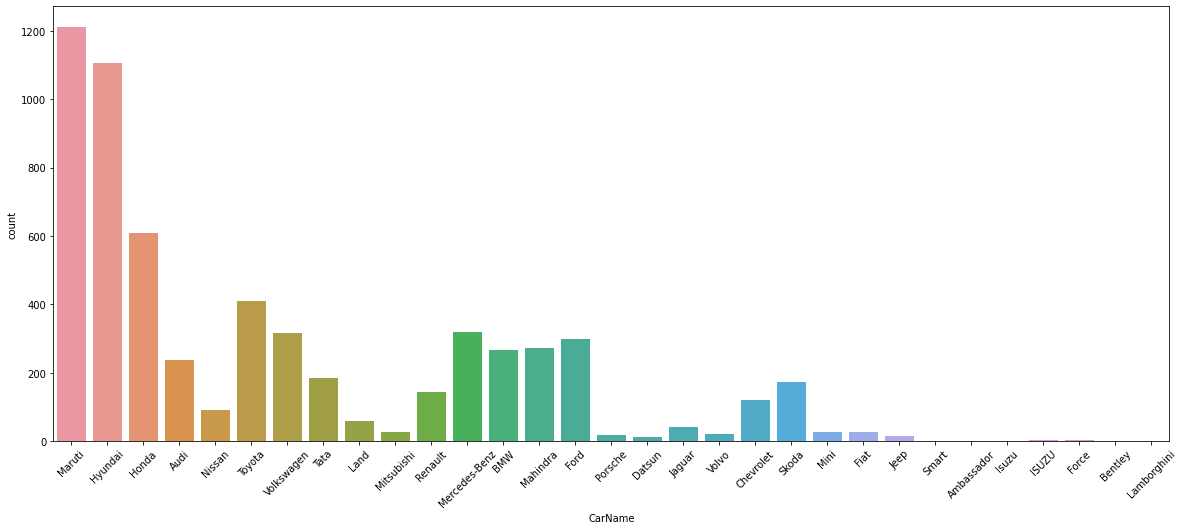

In [59]:
plt.figure(figsize=(20,8))
carplot=sns.countplot(data['CarName'])
carplot.set_xticklabels(carplot.get_xticklabels(), rotation=45)
plt.show()

- Most sold cars are Maruti, Hyundai and  Honda(generally having lower prices) and Least sold are lambhorghini ,bentley etc. which are very expensive ones.
- So selling is inversely proportional to car price.

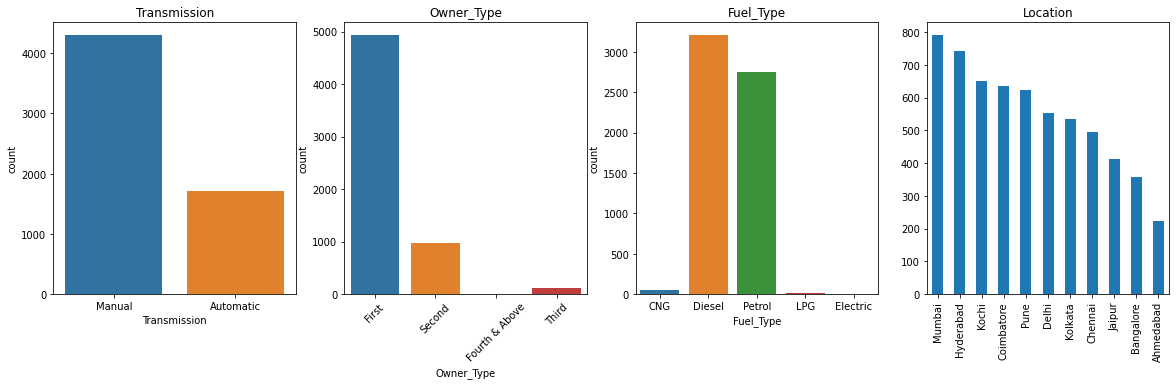

In [60]:
fig, axis = plt.subplots(1,4, figsize = (20,5))

plt.subplot(axis[0])
axis[0].title.set_text('Transmission')
sns.countplot(data['Transmission'])

plt.subplot(axis[1])
axis[1].title.set_text('Owner_Type')
ownerplot=sns.countplot(data['Owner_Type'])
ownerplot.set_xticklabels(ownerplot.get_xticklabels(),rotation=45)

plt.subplot(axis[2])
axis[2].title.set_text('Fuel_Type')
sns.countplot(data['Fuel_Type'])

plt.subplot(axis[3])
axis[3].title.set_text('Location')
data['Location'].value_counts().plot(kind='bar')


**Comments:-**
- Mumbai has maximum sell of cars.
- 71.4% of the cars are of Manual transmision and remaining(28.6%) are Automatic geared vehicles.
- 81.9% of First owner type are ready to sell their cars.
- 3000+ cars which are ready to sell are of Diesel fuel type.

**One Hot Encoding**

In [61]:
enc = preprocessing.OneHotEncoder()
fuels = pd.DataFrame(enc.fit_transform(data[['Fuel_Type']]).toarray(), columns=['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'] )
data.drop('Fuel_Type',axis=1,inplace=True)

owners = pd.DataFrame(enc.fit_transform(data[['Owner_Type']]).toarray(), columns=['First',  'Fourth & Above','Second', 'Third'] )
data.drop('Owner_Type',axis=1,inplace=True)

transmission = pd.DataFrame(enc.fit_transform(data[['Transmission']]).toarray(), columns=['Automatic','Manual'] )
data.drop('Transmission',axis=1,inplace=True)

data = pd.concat([data,fuels,owners,transmission],axis=1)

**Creating new features**

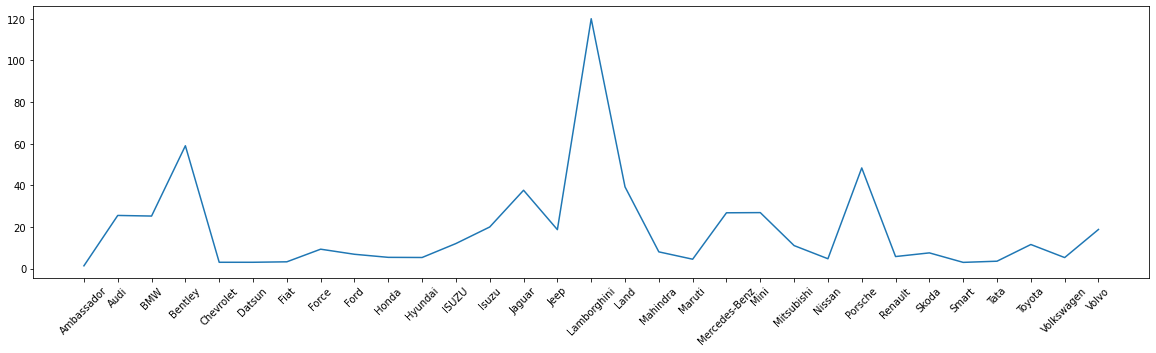

In [62]:
plt.figure(figsize=(20,5))
model_price = plt.plot(data.groupby('CarName')['Price'].mean())
plt.xticks(rotation=45)
plt.show()

In [81]:
cheap_cars, moderate_cars, expensive_cars = [], [], []
for i in range(len(data)):
    car = data.loc[i,'CarName']
    if ( data.loc[i,'Price'] > 80 ) : 
          if car not in expensive_cars : 
            expensive_cars.append(car)
    elif (data.loc[i,'Price']>=30) : 
          if car not in moderate_cars : 
            moderate_cars.append(car)
    else :
          if car not in cheap_cars : 
            cheap_cars.append(car)


In [83]:
data['expensive_cars'] = data['CarName'].apply(lambda x : 1 if x in expensive_cars else 0) 
data['moderate_cars'] = data['CarName'].apply(lambda x : 1 if  x in moderate_cars else 0 )
data['common_man']  = data['CarName'].apply(lambda x : 1 if x in cheap_cars else 0)

In [84]:
data.drop('CarName',axis=1, inplace=True)
data.drop('Name',axis=1,inplace=True)

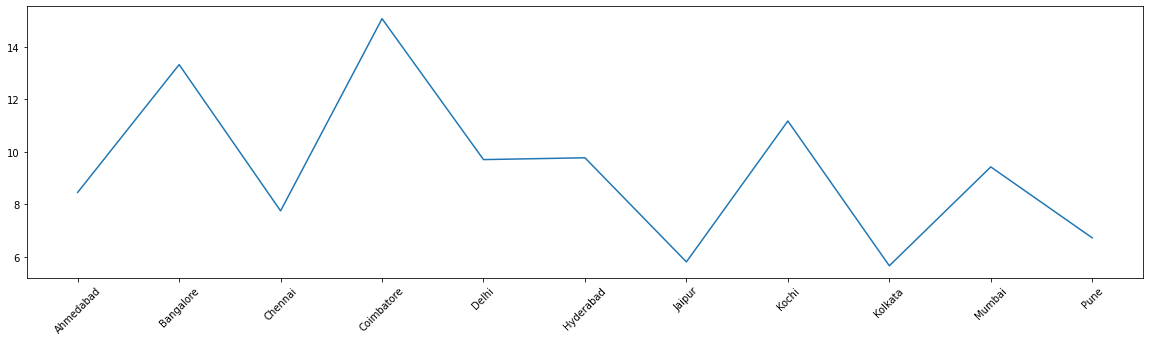

In [97]:
plt.figure(figsize=(20,5))
model_price = plt.plot(data.groupby('Location')['Price'].mean())
plt.xticks(rotation=45)
plt.show()

In [99]:
rich_loc, not_rich_loc = [], []
for i in range(len(data)):
    loc = data.loc[i,'Location']
    if ( data.loc[i,'Price'] > 12 ) : 
          if car not in rich_loc : 
            rich_loc.append(loc)
    else :
          if car not in not_rich_loc : 
            not_rich_loc.append(loc)


In [100]:
data['rich_loc'] = data['Location'].apply(lambda x : 1 if x in rich_loc else 0) 
data['not_rich_loc'] = data['Location'].apply(lambda x : 1 if  x in not_rich_loc else 0 )

In [101]:
data.drop('Location',axis=1,inplace=True)

**Select ML algorithm and Train the model**
<br><br>
**1) linear regression**

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression

In [103]:
#Performing Test_Train Split
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.20)

In [104]:
linear=LinearRegression().fit(X_train,y_train)

In [106]:
y_pred=linear.predict(X_test)
print("R2 Score : ", r2_score(y_test,y_pred))

R2 Score :  0.7444156778437345


**2) XGBoost Algorithm**

In [107]:
from xgboost import XGBRegressor 
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [111]:
y_pred = xgb.predict(X_test)
print("R2 Score : ", r2_score(y_pred,y_test))

R2 Score :  0.8982995171343073


**KNN Regressor**

In [113]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [114]:
y_pred = knn_reg.predict(X_test)
print("R2 Score : ",r2_score(y_pred,y_test))

R2 Score :  0.4618797475816029


Clearly XGBoost Won the game . If we spent some more time in selecting/creating features which are more relevent than others than we might end up getting even better results.

**Please note that in many cases even linear regression performs very nicely if good data is provided**

**Conclusion** This analysis has shown that car prices depends on factors like location, model and obviously feature of car like no of seats, mileage etc. we tried to built a ML model to predict the price of car based on data we already have. 
<br><br>

*Thank you for reading.* 